# Metrics Testing Notebook
This notebook is designed to illustrate how to use / test each of our four metrics: 
1. Topk Retrieval
2. Linear Seperability
3. K-nn angles
4. Downstream Captioning

In [ ]:
# Import necessary libraries
import torch
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt

# Import metrics
from metrics.topk import TopKMetric
from metrics.linearSeparability import SeperabilityMetric
from metrics.entropy import EntropyMetric
from metrics.captioning import CaptioningMetric

# Import model and dataset utilities
from Models.clipModel import CLIPModel
from datasetLoader import DatasetLoader

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/Users/tsumacpro/CardElephant/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu
Using device: cpu


## Setup: Load CLIP Model and Dataset
First, we'll load a CLIP model and a dataset to generate embeddings for testing our metrics.

In [2]:
# Initialize CLIP model
clip_model = CLIPModel(model_name="ViT-B/32", device=device)
print("CLIP model loaded successfully")

# Load a sample of the COCO dataset
print("\nLoading COCO dataset...")
data_samples = DatasetLoader.load_coco_dataset(
    data_dir="data",
    split="val2017",
    max_samples=100  # Start with a small sample for testing
)
print(f"Loaded {len(data_samples)} samples")

2025-10-22 22:58:37,249 - INFO - Loading COCO val2017 dataset...
2025-10-22 22:58:37,268 - INFO - Loaded 100 COCO samples
2025-10-22 22:58:37,268 - INFO - Loaded 100 COCO samples


CLIP model loaded successfully

Loading COCO dataset...
Loaded 100 samples


## Generate Embeddings
Generate image and text embeddings for the loaded dataset using CLIP.

In [3]:
# Generate embeddings for images and texts
print("Generating embeddings...")
image_embeddings = []
text_embeddings = []

for sample in data_samples:
    # Generate image embedding
    img_emb = clip_model.encode_images([sample["image_path"]])[0]
    image_embeddings.append(img_emb)
    
    # Generate text embedding
    txt_emb = clip_model.encode_text([sample["text"]])[0]
    text_embeddings.append(txt_emb)

print(f"Generated {len(image_embeddings)} image embeddings")
print(f"Generated {len(text_embeddings)} text embeddings")
print(f"Embedding dimension: {image_embeddings[0].shape}")

Generating embeddings...
Generated 100 image embeddings
Generated 100 text embeddings
Embedding dimension: torch.Size([512])
Generated 100 image embeddings
Generated 100 text embeddings
Embedding dimension: torch.Size([512])


In [ ]:
# visualize 2d projection of embeddings using PCA, coloring by image vs text
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

all_embeddings = torch.cat(image_embeddings + text_embeddings, dim=0).cpu().numpy()
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(all_embeddings)

# Create labels for coloring
labels = ['image' if i < len(image_embeddings) else 'text' for i in range(len(all_embeddings))]

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
plt.title("2D PCA Projection of Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()



## Metric 1: Top-K Retrieval
This metric measures how well the model retrieves the correct text caption given an image embedding. It computes the percentage of images where the correct text is in the top-k most similar text embeddings.

100 100
{1: 0.26}
{1: 0.26, 5: 0.92}
{1: 0.26, 5: 0.92, 10: 0.99}
{1: 0.26, 5: 0.92, 10: 0.99, 100: 1.0}


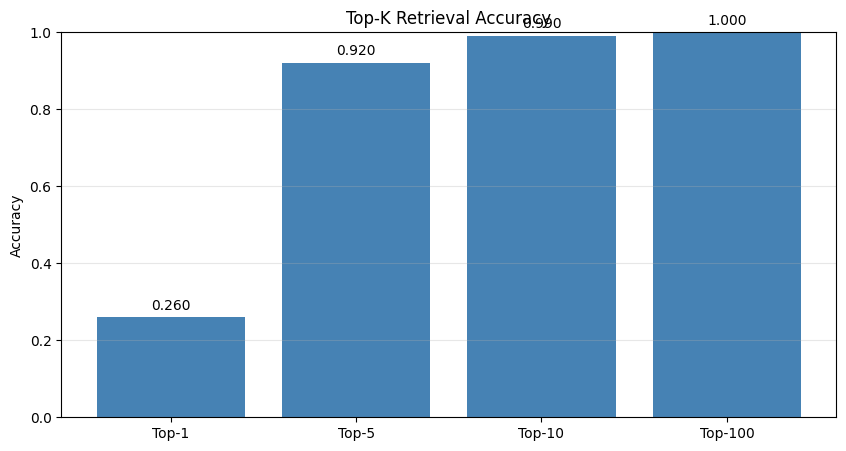

In [4]:
# Prepare data for Top-K metric
# Format: List[Tuple[List[text_embeddings], image_embedding]]
# For each image, we need all text embeddings and the image embedding
topk_data = []

print(len(text_embeddings), len(image_embeddings))

embeddings = list(zip([[x] for x in text_embeddings], image_embeddings))

# Test with different k values
k_values = [1, 5, 10, 100]
topk_results = {}

for k in k_values:
    metric = TopKMetric(k=k)
    score, _ = metric.compute(embeddings)
    topk_results[k] = score
    print(topk_results)
    # print(f"Top-{k} Retrieval Accuracy: {score:.4f} ({score*100:.2f}%)")

# Visualize results
plt.figure(figsize=(10, 5))
plt.bar([f"Top-{k}" for k in k_values], [topk_results[k] for k in k_values], color='steelblue')
plt.ylabel('Accuracy')
plt.title('Top-K Retrieval Accuracy')
plt.ylim([0, 1])
for i, k in enumerate(k_values):
    plt.text(i, topk_results[k] + 0.02, f'{topk_results[k]:.3f}', ha='center')
plt.grid(axis='y', alpha=0.3)
plt.show()

## Metric 2: Linear Separability
This metric trains a linear classifier to distinguish between image and text embeddings. Lower accuracy means the embeddings are more aligned (less separable), which is desirable for multimodal models.

In [5]:
# Prepare data for Linear Separability metric
# Format: List[Tuple[image_embedding, text_embedding]]
separability_data = [(img_emb.unsqueeze(0), txt_emb.unsqueeze(0)) 
                     for img_emb, txt_emb in zip(image_embeddings, text_embeddings)]

# Compute linear separability
print("Training linear classifier to measure separability...")
metric = SeperabilityMetric(n_epochs=100, lr=1e-3)
separability_score = metric.compute(separability_data)

print(f"\nLinear Separability Accuracy: {separability_score:.4f} ({separability_score*100:.2f}%)")
print(f"Alignment Score (1 - separability): {1-separability_score:.4f}")
print("\nNote: Lower separability (closer to 0.5) indicates better alignment between modalities")

Training linear classifier to measure separability...
Epoch [1/100], Loss: 0.7431
Epoch [2/100], Loss: 0.7013
Epoch [3/100], Loss: 0.6613
Epoch [4/100], Loss: 0.6232
Epoch [5/100], Loss: 0.5870
Epoch [6/100], Loss: 0.5527
Epoch [7/100], Loss: 0.5203
Epoch [8/100], Loss: 0.4898
Epoch [9/100], Loss: 0.4610
Epoch [10/100], Loss: 0.4340
Epoch [11/100], Loss: 0.4086
Epoch [12/100], Loss: 0.3849
Epoch [13/100], Loss: 0.3626
Epoch [14/100], Loss: 0.3418
Epoch [15/100], Loss: 0.3224
Epoch [16/100], Loss: 0.3042
Epoch [17/100], Loss: 0.2873
Epoch [18/100], Loss: 0.2714
Epoch [19/100], Loss: 0.2567
Epoch [20/100], Loss: 0.2429
Epoch [21/100], Loss: 0.2301
Epoch [22/100], Loss: 0.2181
Epoch [23/100], Loss: 0.2069
Epoch [24/100], Loss: 0.1965
Epoch [25/100], Loss: 0.1868
Epoch [26/100], Loss: 0.1777
Epoch [27/100], Loss: 0.1693
Epoch [28/100], Loss: 0.1614
Epoch [29/100], Loss: 0.1541
Epoch [30/100], Loss: 0.1472
Epoch [31/100], Loss: 0.1408
Epoch [32/100], Loss: 0.1348
Epoch [33/100], Loss: 0.129

## Metric 3: K-NN Angles (Entropy Proxy)
This metric computes the average angle to the k-th nearest neighbor for embeddings on the unit hypersphere. It serves as a proxy for entropy - larger angles indicate more uniform distribution (higher entropy).

Computing K-NN angle metrics...
Average 1-NN angle: 0.0966 radians (5.53°)
Average 3-NN angle: 0.1428 radians (8.18°)
Average 1-NN angle: 0.0966 radians (5.53°)
Average 3-NN angle: 0.1428 radians (8.18°)
Average 5-NN angle: 0.2581 radians (14.79°)
Average 10-NN angle: 0.2829 radians (16.21°)
Average 5-NN angle: 0.2581 radians (14.79°)
Average 10-NN angle: 0.2829 radians (16.21°)


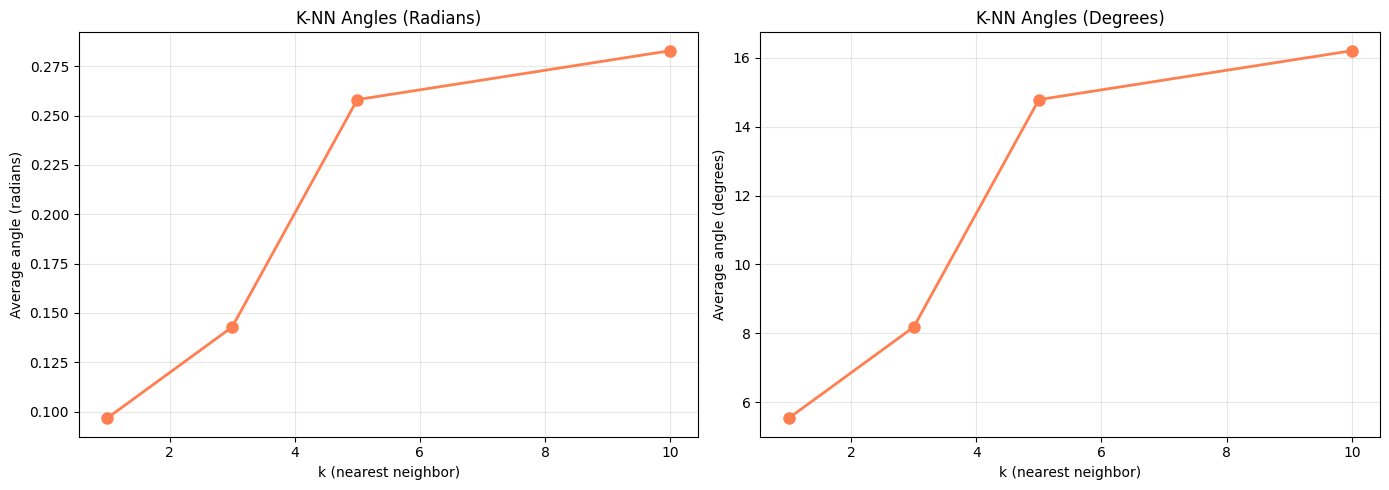


Note: Larger angles indicate more uniform distribution (higher entropy)


In [6]:
# Prepare data for Entropy metric
# Format: List[Tuple[List[text_embeddings], image_embedding]]
# We'll use a subset of embeddings (5 text embeddings per image)
entropy_data = []
for i in range(len(image_embeddings)):
    # For each image, include its text and a few other texts
    num_texts = min(5, len(text_embeddings))
    text_subset = [text_embeddings[i]] + [text_embeddings[j] for j in range(len(text_embeddings)) 
                                          if j != i][:num_texts-1]
    entropy_data.append((text_subset, image_embeddings[i]))

# Test with different k values
k_values = [1, 3, 5, 10]
entropy_results = {}

print("Computing K-NN angle metrics...")
for k in k_values:
    metric = EntropyMetric(k=k)
    angle = metric.compute(entropy_data)
    angle_degrees = np.degrees(angle)
    entropy_results[k] = angle
    print(f"Average {k}-NN angle: {angle:.4f} radians ({angle_degrees:.2f}°)")

# Visualize results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot in radians
ax1.plot(k_values, [entropy_results[k] for k in k_values], 'o-', color='coral', linewidth=2, markersize=8)
ax1.set_xlabel('k (nearest neighbor)')
ax1.set_ylabel('Average angle (radians)')
ax1.set_title('K-NN Angles (Radians)')
ax1.grid(True, alpha=0.3)

# Plot in degrees
ax2.plot(k_values, [np.degrees(entropy_results[k]) for k in k_values], 'o-', color='coral', linewidth=2, markersize=8)
ax2.set_xlabel('k (nearest neighbor)')
ax2.set_ylabel('Average angle (degrees)')
ax2.set_title('K-NN Angles (Degrees)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nNote: Larger angles indicate more uniform distribution (higher entropy)")

## Metric 4: Downstream Captioning
This metric evaluates the quality of embeddings by fine-tuning a captioning model and measuring BLEU scores. This is a more intensive test that requires training a model.

**Note:** This metric requires significant computation and training time. We'll demonstrate the setup but use a small subset for testing.

In [ ]:
# Captioning metric requires training a model, which is computationally expensive
# Here we show how to set it up, but keep it commented for quick testing

# Prepare data for Captioning metric
# Format: List[Tuple[image_embedding, text_embedding]] and List[captions]
captioning_data = [(img_emb, txt_emb) for img_emb, txt_emb in zip(image_embeddings, text_embeddings)]
captions = [sample["text"] for sample in data_samples]

print("Captioning Metric Setup:")
print(f"Number of image-text pairs: {len(captioning_data)}")
print(f"Number of captions: {len(captions)}")
print(f"\nExample caption: {captions[0]}")

print("\nTraining captioning model...")
metric = CaptioningMetric()
bleu_score = metric.compute(captioning_data, captions, clip_model=clip_model)
print(f"BLEU Score: {bleu_score:.4f}")


Captioning Metric Setup:
Number of image-text pairs: 100
Number of captions: 100

Example caption: A black Honda motorcycle parked in front of a garage.

Training captioning model...


2025-10-22 22:58:48,990 - INFO - Loading COCO train2017 dataset...


Loading COCO dataset...


2025-10-22 22:58:49,435 - INFO - Loaded 1000 COCO samples


Loaded 1000 samples
Training samples: 800
Validation samples: 200


python(8231) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Pre-computing image embeddings...


 28%|██▊       | 7/25 [00:10<00:39,  2.20s/it]

### Alternative: Quick Captioning Demo
For a faster demonstration, we can show how to use the captioning training functions from the metrics module without the full metric computation.

In [ ]:
# Quick demo: Train a captioning model on a very small subset
# This shows the workflow without the full computational cost

from metrics.captioning import train_caption_model, plot_training_metrics, test_caption_generation

# Use only first 20 samples for quick demo
small_subset = data_samples[:20]

# Uncomment to run quick demo

trained_model, losses, bleu_scores = train_caption_model(
    clip_model=clip_model,
    data_samples=small_subset,
    num_epochs=2,
    batch_size=4
)

# Plot training progress
plot_training_metrics(losses, bleu_scores)

# Test caption generation
test_caption_generation(trained_model, clip_model, small_subset, num_samples=3)


TypeError: ClipCaptionModel.__init__() got an unexpected keyword argument 'gpt2_type'

## Summary and Comparison
Let's summarize all the metrics we've tested and their implications.

In [ ]:
# Create a summary table of all metrics
import pandas as pd

summary_data = {
    'Metric': [
        'Top-1 Retrieval',
        'Top-5 Retrieval', 
        'Top-10 Retrieval',
        'Top-20 Retrieval',
        'Linear Separability',
        '5-NN Average Angle',
    ],
    'Score': [
        topk_results[1],
        topk_results[5],
        topk_results[10],
        topk_results[20],
        separability_score,
        np.degrees(entropy_results[5])  # Convert to degrees for readability
    ],
    'Interpretation': [
        'Higher is better (retrieval accuracy)',
        'Higher is better (retrieval accuracy)',
        'Higher is better (retrieval accuracy)',
        'Higher is better (retrieval accuracy)',
        'Lower is better (less separable = more aligned)',
        'Higher is better (more uniform distribution)'
    ]
}

df_summary = pd.DataFrame(summary_data)
print("Metric Summary:")
print("="*80)
print(df_summary.to_string(index=False))
print("="*80)

# Create a comprehensive visualization
fig = plt.figure(figsize=(15, 10))

# Top-K Retrieval
ax1 = plt.subplot(2, 2, 1)
bars = ax1.bar([f"k={k}" for k in k_values], [topk_results[k] for k in k_values], color='steelblue')
ax1.set_ylabel('Accuracy')
ax1.set_title('Top-K Retrieval Performance', fontsize=12, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.3f}', ha='center', va='bottom')

# Linear Separability
ax2 = plt.subplot(2, 2, 2)
ax2.bar(['Separability', 'Alignment\n(1-Sep)'], 
        [separability_score, 1-separability_score], 
        color=['coral', 'lightgreen'])
ax2.set_ylabel('Score')
ax2.set_title('Linear Separability vs Alignment', fontsize=12, fontweight='bold')
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)
ax2.text(0, separability_score + 0.02, f'{separability_score:.3f}', ha='center')
ax2.text(1, (1-separability_score) + 0.02, f'{1-separability_score:.3f}', ha='center')

# K-NN Angles (in degrees)
ax3 = plt.subplot(2, 2, 3)
ax3.plot(k_values, [np.degrees(entropy_results[k]) for k in k_values], 
         'o-', color='coral', linewidth=2, markersize=8)
ax3.set_xlabel('k (nearest neighbor)')
ax3.set_ylabel('Average angle (degrees)')
ax3.set_title('K-NN Angles (Entropy Proxy)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Combined metric overview
ax4 = plt.subplot(2, 2, 4)
metric_names = ['Top-5\nRetrieval', 'Alignment\n(1-Sep)', '5-NN Angle\n(normalized)']
# Normalize 5-NN angle to 0-1 scale for comparison (assuming max ~180 degrees)
normalized_scores = [
    topk_results[5],
    1 - separability_score,
    np.degrees(entropy_results[5]) / 180.0
]
colors = ['steelblue', 'lightgreen', 'coral']
bars = ax4.bar(metric_names, normalized_scores, color=colors)
ax4.set_ylabel('Normalized Score')
ax4.set_title('Metric Overview (Higher is Better)', fontsize=12, fontweight='bold')
ax4.set_ylim([0, 1])
ax4.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

KeyError: 20

## Conclusion and Interpretation

### Metric Meanings:

1. **Top-K Retrieval**: Measures how well images can retrieve their corresponding text captions
   - Higher scores indicate better alignment between image and text embeddings
   - Top-1 is strictest, Top-K increases with k

2. **Linear Separability**: Measures how easily a classifier can distinguish image vs text embeddings
   - Lower scores (closer to 0.5) indicate better multimodal alignment
   - Higher scores indicate the modalities are easily separable (less aligned)

3. **K-NN Angles (Entropy Proxy)**: Measures the distribution uniformity of embeddings
   - Larger angles indicate more uniform distribution on the hypersphere
   - This proxy for entropy tells us about the coverage of the embedding space

4. **Downstream Captioning**: Evaluates embedding quality through a downstream task
   - BLEU scores measure caption generation quality
   - Higher scores indicate embeddings contain useful semantic information

### Usage Tips:
- Run all cells in order to see the complete analysis
- Adjust `max_samples` in the dataset loading to test with different dataset sizes
- Uncomment the captioning sections if you have sufficient computational resources
- Use these metrics to compare different CLIP models or training approaches